In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from scipy.io import loadmat
from tqdm import tqdm
import multiprocessing as mp
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import PIL.ImageOps as pop
import seaborn as sns
%matplotlib inline

In [ ]:
from src.fwrf import fpX
from src.fwrf import iterate_minibatches
from src.plots import mosaic_vis
from src.file_utility import save_stuff

In [2]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [3]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print "Current dir: %s" % root_dir
print "Time Stamp: %s" % timestamp

Current dir: /home/styvesg/Documents/PostDoc/GitRepo/nsd/
Time Stamp: Aug-12-2019_1424


## Load a dataset to test what our network is doing

In [5]:
nsd_root = "/repo.local2/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [6]:
exp_design = loadmat(exp_design_file)

In [7]:
print exp_design.keys()

['__globals__', 'masterordering', 'subjectim', 'sharedix', '__header__', 'basiccnt', 'stimpattern', '__version__']


In [8]:
basic_cnt    = exp_design['basiccnt']
shared_idx   = exp_design['sharedix']
subject_idx  = exp_design['subjectim']
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']

In [9]:
print np.min(trial_order), np.max(trial_order)

1 10000


In [10]:
print "Loading block..."
image_data_set = h5py.File(stim_file)
print image_data_set.keys()
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print image_data.shape

Loading block...
[u'imgBrick']


In [13]:
print shared_idx.shape
print np.min(shared_idx), np.max(shared_idx)

(1, 1000)
2951 72949


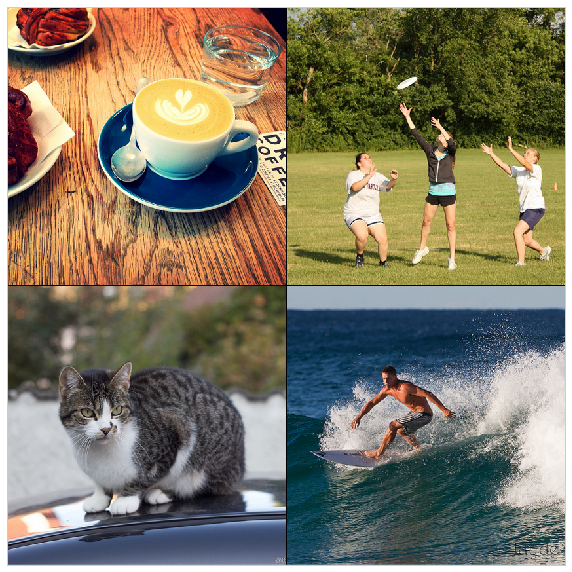

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(mosaic_vis(image_data[shared_idx[0,6:10]-1].astype(np.float32), pad=2), cmap='gray', interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# COCO indices
## Create a block of COCO IDs concordant with the 'subjectim' array 

In [6]:
import pandas as pd
nsd_stiminfo_file = '/repo.local2/datasets/nsd/dev/nsd_stim_info_merged.pkl'
stiminfo = pd.read_pickle(nsd_stiminfo_file)

In [11]:
subject_idx  = exp_design['subjectim']
print subject_idx.shape

cocoId_arr = np.zeros(shape=subject_idx.shape, dtype=int)
crop_arr   = np.zeros(shape=subject_idx.shape+(4,), dtype=np.float32)
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)] 
    imageId = subject_idx[j]-1
    for i,k in enumerate(imageId):
        cocoId_arr[j,i] = (cocoId[nsdId==k])[0]
        crop_arr[j,i]   = stiminfo['cropBox'][k]

(8, 10000)


In [12]:
save_stuff("%snsd_to_coco_indice_map"%(stim_root), {'cocoId': cocoId_arr, 'crop': crop_arr})

saved cocoId in h5py file
saved crop in h5py file


---

# Subject-wise image block
## Native resolution

In [16]:
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1].transpose(0,3,1,2)
    print s_image_data.shape
    save_stuff("%sS%d_stimuli_native"%(stim_root, k+1), {'stimuli': s_image_data})

(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file


## Downsampled resolution

In [ ]:
def resize_image_tensor(x, newsize):
    tt = x.transpose((0,2,3,1))
    r  = np.ndarray(shape=x.shape[:1]+newsize+(x.shape[1],), dtype=tt.dtype) 
    for i,t in enumerate(tt):
        r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))
    return r.transpose((0,3,1,2))   

In [65]:
nx = 227
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1]
    s_image_data = resize_image_tensor(s_image_data.transpose(0,3,1,2), newsize=(nx,nx))

    print s_image_data.shape
    save_stuff("%sS%d_stimuli_%d"%(stim_root, k+1, nx), {'stimuli': s_image_data})

(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file


# An example of a COCO-derived subject-wise label block
## Reload 

In [17]:
subject = 1

In [18]:
coco_info_set = h5py.File(stim_root + 'nsd_to_coco_indice_map.h5py')
cocoId_arr = np.copy(coco_info_set['cocoId'])
nsdcrop_arr = np.copy(coco_info_set['crop'])
coco_info_set.close()

image_data_set = h5py.File(stim_root + "S%d_stimuli.h5py"%subject)
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print image_data.shape
print image_data.dtype
print np.min(image_data[0]), np.max(image_data[0])

(10000, 3, 227, 227)
uint8
0 255


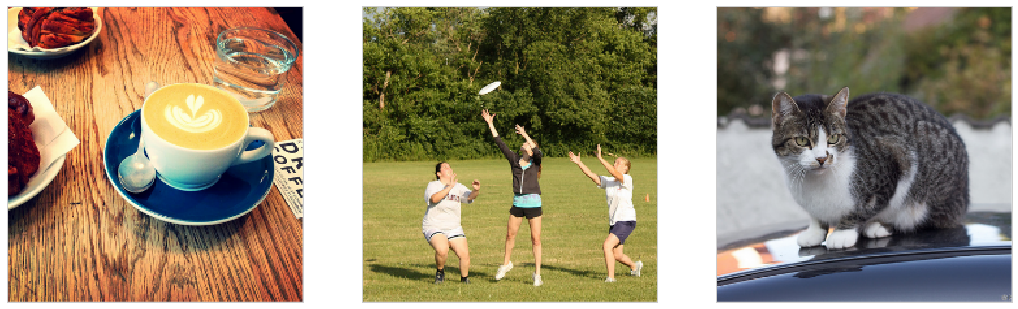

In [19]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [20]:
import json
from collections import defaultdict

annDir = '/repo.local2/datasets/coco/annotations/'
imgDir = annDir + 'panoptic_train2017/' # combined folder with train2017 and val2017 png masks
panop_trn_annFile = annDir + 'panoptic_train2017.json'
panop_val_annFile = annDir + 'panoptic_val2017.json'

dataset = dict()
dataset = json.load(open(panop_trn_annFile, 'r'))

imgIdToAnns = defaultdict(list)
catIdToCat = defaultdict(list)
if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)
    for cat in dataset['categories']:
        catIdToCat[cat['id']].append(cat)
dataset = dict()
dataset = json.load(open(panop_val_annFile, 'r'))
if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

In [21]:
def applyCropToImg(img, box):
    '''
    applyCropToImg(img, cropBox)
    img ~ any h x w x n image
    cropBox ~ (top, bottom, left, right) in fractions of image size
    '''
    if box[0]+box[1] >= 1:
        raise ValueError('top and bottom crop must sum to less than 1')
    if box[2]+box[3] >= 1:
        raise ValueError('left and right crop must sum to less than 1')
    shape = img.shape
    topCrop = np.round(shape[0]*box[0]).astype(int)
    bottomCrop = np.round(shape[0]*box[1]).astype(int)
    leftCrop = np.round(shape[1]*box[2]).astype(int)
    rightCrop = np.round(shape[1]*box[3]).astype(int)
    croppedImage = img[topCrop:(shape[0]-bottomCrop),leftCrop:(shape[1]-rightCrop)]
    return croppedImage
def fillEmpty(img, value_to_fill=0):
    # replace every zero with a value of one of its neighbouring pixel
    x,y = img.shape
    flat_img = img.flatten()
    while value_to_fill in flat_img:
        zidx = np.arange(len(flat_img))[flat_img==value_to_fill]
        for z in zidx:
            i,j = z%x, z//x
            sidx = [(j*x+i-1 if i>0 else None),
                    (j*x+i+1 if i<x-1 else None),
                    ((j-1)*x+i if j>0 else None),
                    ((j+1)*x+i if j<y-1 else None),
                    ((j-1)*x+i-1 if j>0 and i>0 else None),
                    ((j-1)*x+i+1 if j>0 and i<x-1 else None),
                    ((j+1)*x+i-1 if j<y-1 and i>0 else None),
                    ((j+1)*x+i+1 if j<y-1 and i<x-1 else None)               
            ]
            if None in sidx:
                sidx = list(set(sidx))
                sidx.remove(None)            
            neighbours = list(flat_img[sidx])
            while value_to_fill in neighbours:
                neighbours.remove(value_to_fill)
            if len(neighbours)>0:
                unique, counts = np.unique(neighbours, return_counts=True)
                flat_img[z] = unique[np.argmax(counts)]
    return flat_img.reshape((x,y))
def maskToIndices(img):
    return img[:,:,0]+img[:,:,1]*256+img[:,:,2]*(256**2)
def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return imgSegIds

def getCategoryIDs(annotations, imgSegIds):
    # getCategoryIDs(imgToAnns[cocoId], imgSegIds)
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds]  

def getCategoryNames(catIdToCat, catIds):
    # getCategoryNames(catToCat, catIds)
    return [catIdToCat[c][0]['name'] for c in catIds]
    
def getSupercategoryNames(catIdToCat, catIds):
    # getSupercategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['supercategory'] for c in catIds])
def supercategoryMap(croppedImg, annotations, embbeding):
    # supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    segmentMap = maskToIndices(croppedImg).flatten()
    superMap = np.full(fill_value=-1, shape=segmentMap.shape, dtype=np.int)
    imgSegIds = maskToUniqueIndices(croppedImg)
    catIds = getCategoryIDs(annotations, imgSegIds)
    for c,s in zip(catIds, imgSegIds):
        supercat = getSupercategoryNames(catIdToCat, [c])[0]
        superMap[segmentMap==s] = embbeding[supercat]            
    return fillEmpty(superMap.reshape(croppedImg.shape[:2]), value_to_fill=-1)

[200, 189, 67, 47, 47, 50]
[u'rug-merged', u'table-merged', u'dining table', u'cup', u'cup', u'spoon']
[u'furniture' u'furniture-stuff' u'kitchen' u'textile']
[184, 193, 1, 1, 1, 34]
[u'tree-merged', u'grass-merged', u'person', u'person', u'person', u'frisbee']
[u'person' u'plant' u'sports']
[184, 17, 3, 185]
[u'tree-merged', u'cat', u'car', u'fence-merged']
[u'animal' u'plant' u'structural' u'vehicle']


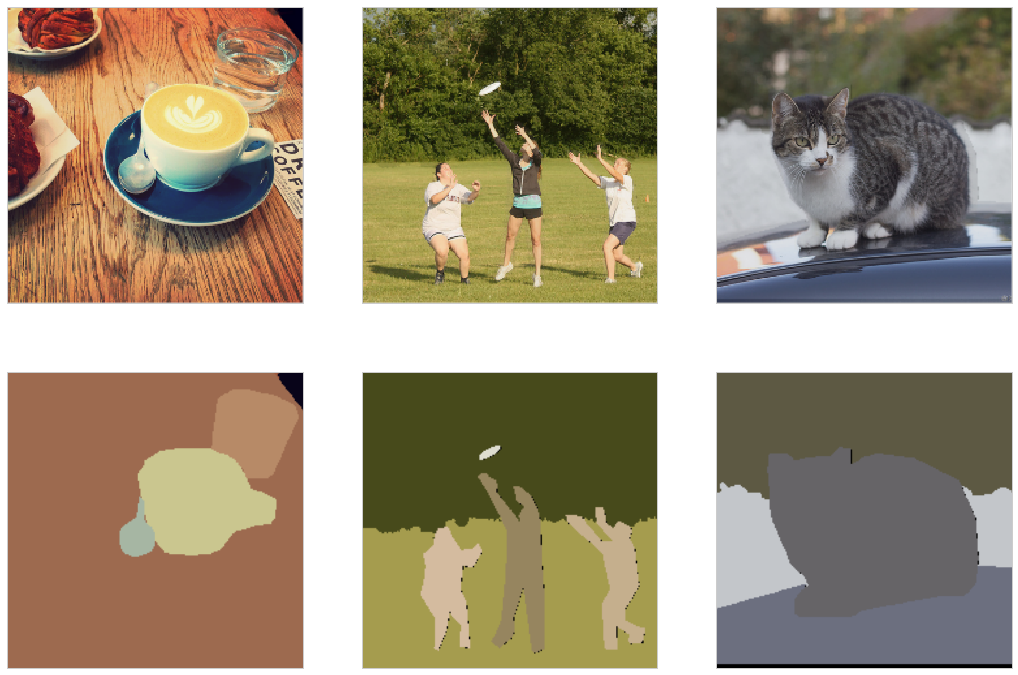

In [22]:
import skimage.io
from skimage.transform import resize
minSize = 227

plt.figure(figsize=(18,12))
for i in range(3):
    cId = cocoId_arr[subject-1,6+i]
    png_name = imgDir + '%012d.png' % cId
    crop = nsdcrop_arr[subject-1,6+i]
    img = skimage.io.imread(png_name)
    
    croppedImg = applyCropToImg(img,crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 255.).astype('uint8')
    plt.subplot(2,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.imshow(croppedImg, alpha=.2)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(2,3,3+i+1)
    plt.imshow(croppedImg) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    ##
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    print catIds
    print getCategoryNames(catIdToCat, catIds)
    print getSupercategoryNames(catIdToCat, catIds)

In [23]:
stuff_annFile = annDir + 'stuff_train2017.json'
thing_annFile = annDir + 'instances_train2017.json'

from pycocotools.coco import COCO
coco_stuff = COCO(stuff_annFile)
coco_thing = COCO(thing_annFile)

loading annotations into memory...
Done (t=23.59s)
creating index...
index created!
loading annotations into memory...
Done (t=16.24s)
creating index...
index created!


In [24]:
# display COCO categories and supercategories
cats = coco_stuff.loadCats(coco_stuff.getCatIds())
stuff_nms=[cat['name'] for cat in cats]
print('COCO stuff categories: \n{}\n'.format(' '.join(stuff_nms)))
super_stuff_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO stuff supercategories: \n{}'.format(' '.join(set(super_stuff_nms))))

print
cats = coco_thing.loadCats(coco_thing.getCatIds())
thing_nms=[cat['name'] for cat in cats]
print('COCO thing categories: \n{}\n'.format(' '.join(thing_nms)))
super_thing_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO thing supercategories: \n{}'.format(' '.join(set(super_thing_nms))))

print 
super_nms = super_thing_nms + super_stuff_nms
print('COCO supercategories: \n{}'.format(' '.join(set(super_nms))))

COCO stuff categories: 
banner blanket branch bridge building-other bush cabinet cage cardboard carpet ceiling-other ceiling-tile cloth clothes clouds counter cupboard curtain desk-stuff dirt door-stuff fence floor-marble floor-other floor-stone floor-tile floor-wood flower fog food-other fruit furniture-other grass gravel ground-other hill house leaves light mat metal mirror-stuff moss mountain mud napkin net paper pavement pillow plant-other plastic platform playingfield railing railroad river road rock roof rug salad sand sea shelf sky-other skyscraper snow solid-other stairs stone straw structural-other table tent textile-other towel tree vegetable wall-brick wall-concrete wall-other wall-panel wall-stone wall-tile wall-wood water-other waterdrops window-blind window-other wood other

COCO stuff supercategories: 
building textile plant floor raw-material sky ceiling water solid window food-stuff furniture-stuff structural other wall ground

COCO thing categories: 
person bicycle ca

In [29]:
print 'super category count = ', len(super_nms)
class_embbeding, label_map = {}, {}
for k,name in enumerate(super_nms):
    class_embbeding[name] = k
    label_map[k] = name 
    print name, ': ', coco_thing.getCatIds(supNms=[name]) + coco_stuff.getCatIds(supNms=[name])

super category count =  28
outdoor :  [10, 11, 13, 14, 15]
food :  [52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
indoor :  [84, 85, 86, 87, 88, 89, 90]
appliance :  [78, 79, 80, 81, 82]
sports :  [34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
person :  [1]
animal :  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
vehicle :  [2, 3, 4, 5, 6, 7, 8, 9]
furniture :  [62, 63, 64, 65, 67, 70]
accessory :  [27, 28, 31, 32, 33]
electronic :  [72, 73, 74, 75, 76, 77]
kitchen :  [44, 46, 47, 48, 49, 50, 51]
building :  [95, 96, 128, 151, 158, 166]
water :  [120, 148, 155, 178, 179]
plant :  [94, 97, 119, 124, 129, 134, 142, 163, 169]
floor :  [101, 114, 115, 116, 117, 118]
raw-material :  [100, 132, 139, 143]
sky :  [106, 157]
ceiling :  [102, 103]
textile :  [92, 93, 104, 105, 109, 131, 137, 141, 152, 167, 168]
solid :  [127, 135, 150, 160, 162, 182]
window :  [180, 181]
food-stuff :  [121, 122, 153, 170]
furniture-stuff :  [98, 107, 108, 110, 112, 123, 130, 133, 156, 161, 165]
ground :  [111, 125, 126, 136, 140,

(227, 227)
(227, 227)
(227, 227)


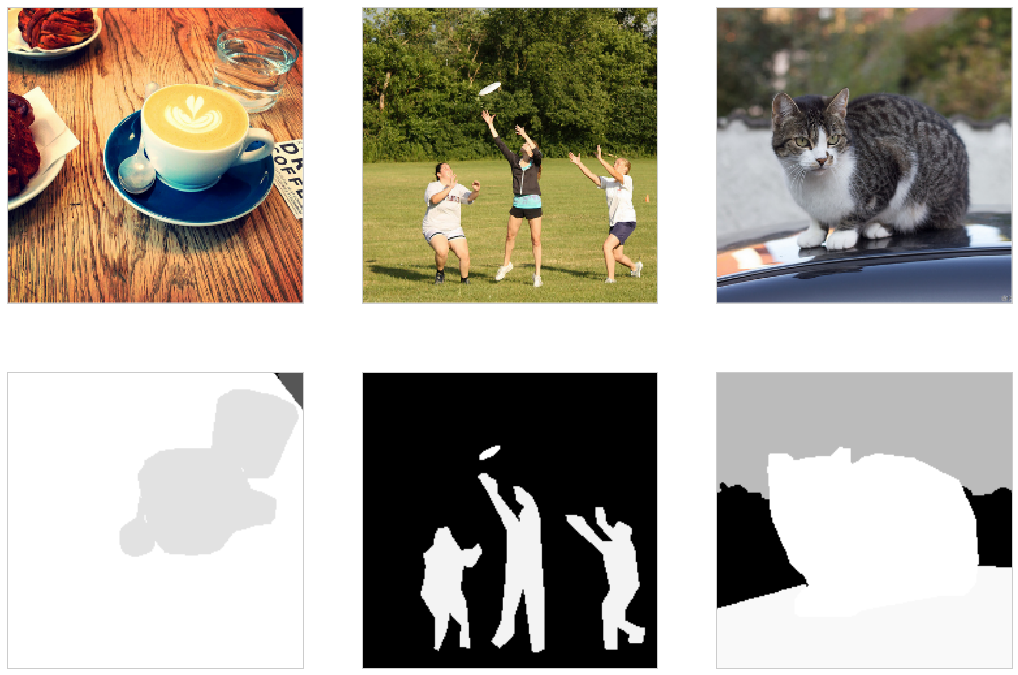

In [31]:
import skimage.io
from skimage.transform import resize
minSize = 227

plt.figure(figsize=(18,12))
for i in range(3):
    cId = cocoId_arr[subject-1,6+i]
    png_name = imgDir + '%012d.png' % cId
    crop = nsdcrop_arr[subject-1,6+i]
    img = skimage.io.imread(png_name)
    
    croppedImg = applyCropToImg(img,crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 255.).astype('uint8')
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    
    plt.subplot(2,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(2,3,3+i+1)
    
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Label maps for all subjects
This takes a long time since we need to load the image and annotations one-by-one and reinterpret them. 

In [33]:
nx = 227
nc = len(super_nms)

for k in range(len(cocoId_arr)): # for all subjects
    l_image_data = np.zeros(shape=(len(cocoId_arr[k]), nx, nx), dtype=np.uint8)

    for i, (cId, crop) in tqdm(enumerate(zip(cocoId_arr[k], nsdcrop_arr[k]))):
        png_name = imgDir + '%012d.png' % cId
        img = skimage.io.imread(png_name)

        croppedImg = applyCropToImg(img, crop)
        croppedImg = (resize(croppedImg, (nx, nx), order=0) * 255.).astype('uint8')
        l_image_data[i,...] = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
        
    print l_image_data.shape
    save_stuff("%sS%d_supercategory_%d"%(stim_root, k+1, nx), {'labels': l_image_data, 'label_map': label_map, 'label_count': nc})

10000it [1:01:23,  1.93it/s]

(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [55:59,  6.39it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [1:00:11,  2.77it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [58:04,  2.87it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [1:00:49,  4.84it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [59:05,  2.82it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [1:00:16,  2.77it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file


10000it [54:38,  3.05it/s]


saved label_count in h5py file
saved label_map as pkl
(10000, 227, 227)
failed to save label_map as h5py. will try pickle
saved labels in h5py file
saved label_count in h5py file
saved label_map as pkl
